In [1]:
import numpy as np  # always need it
import pylab as pl  # do the plots
import ot  # ot
import time
import csv
import random
import pandas as pd
import os
import matplotlib.pyplot as plt


## Extract files from SINUS data, each file should contain heartbeats preprocessed as numerical arrays. The following block of code will compile all heartbeats into a single two dimensional matrix.

In [2]:

directory_path = r"C:\Users\fanga\OneDrive\Documents\Fall 2023\elec 594\THC Docs\Freddy's Code\ArraySINUS"
key = "ID"

matching_files = [filename for filename in os.listdir(directory_path) if key in filename]

columnName = ["filename", "Reference", "Patient", "heartbeatIDX"]
dfSinus = pd.DataFrame(columns=columnName)
beatsSinus = np.array([])
fileDictSinus = {}
patientDictSinus = {}
patientBeatCountSINUS = {}
counter = 0

for filename in matching_files:
    file_path = os.path.join(directory_path, filename)
    
    data = np.loadtxt(file_path, delimiter=',')
    nan_rows = np.any(np.isnan(data), axis=1)
    data = data[~nan_rows]
    
    n = len(data)
    
    dataPd = {
        'filename':  [filename for i in range(n)],
        'Reference': [filename[:7] for i in range(n)],
        'Patient': [filename[11:17] for i in range(n)],
        'heartbeatIDX': [i for i in range (n)]
    }
    dataPd = pd.DataFrame(dataPd)
    dfSinus = pd.concat((dfSinus,dataPd), ignore_index=True)
    if len(beatsSinus) == 0:
        beatsSinus = data
    else:
        beatsSinus = np.vstack((beatsSinus, data))
        
    start = counter
    end = start + len(data) - 1
    counter = end + 1
    fileDictSinus[filename[:7]] = (start, end)
    
    if filename[11:17] in patientDictSinus:
        patientDictSinus[filename[11:17]].append((start, end))
        patientBeatCountSINUS[filename[11:17]] += len(data)
    else:
        patientDictSinus[filename[11:17]] = [(start,end)]
        patientBeatCountSINUS[filename[11:17]] = len(data)

# Extract files from JET data

In [3]:
directory_path = r"C:\Users\fanga\OneDrive\Documents\Fall 2023\elec 594\THC Docs\Freddy's Code\ArrayJET"
key = "ID"

matching_files = [filename for filename in os.listdir(directory_path) if key in filename]

columnName = ["filename", "Reference", "Patient", "heartbeatIDX"]
dfJet = pd.DataFrame(columns=columnName)
beatsJet = np.array([])

fileDictJET = {}
patientDictJET = {}
patientBeatCountJET = {}
counter = 0

for filename in matching_files:
    file_path = os.path.join(directory_path, filename)
    data = np.loadtxt(file_path, delimiter=',')
    nan_rows = np.any(np.isnan(data), axis=1) if data.ndim == 2 else np.any(np.isnan(data))
    data = data[~nan_rows]
    
    n = len(data)
    
    dataPd = {
        'filename':  [filename for i in range(n)],
        'Reference': [filename[:7] for i in range(n)],
        'Patient': [filename[11:17] for i in range(n)],
        'heartbeatIDX': [i for i in range (n)]
    }
    dataPd = pd.DataFrame(dataPd)
    dfJet = pd.concat((dfJet,dataPd), ignore_index=True)
    if len(beatsJet) == 0:
        beatsJet = data
    else:
        beatsJet = np.vstack((beatsJet, data))
    
    start = counter
    end = start + len(data) - 1
    counter = end + 1
    fileDictJET[filename[:7]] = (start, end)
    
    if filename[11:17] in patientDictJET:
        patientDictJET[filename[11:17]].append((start, end))
        patientBeatCountJET[filename[11:17]] += len(data)
    else:
        patientDictJET[filename[11:17]] = [(start,end)]
        patientBeatCountJET[filename[11:17]] = len(data)


# Center data into probabilities with highest peak at the midpoint.

In [4]:
sinusPeaks = np.argmax(beatsSinus, axis=1)
jetPeaks = np.argmax(beatsJet, axis=1)
beatsSinusCentered = np.zeros((beatsSinus.shape[0], beatsSinus.shape[1]))
beatsJetCentered = np.zeros((beatsJet.shape[0], beatsJet.shape[1]))
for i in range(len(beatsSinus)):
    beatsSinusCentered[i,:] = np.roll(beatsSinus[i], 50 - int(np.round(sinusPeaks[i]))) 
for i in range(len(beatsJet)):
    beatsJetCentered[i,:] = np.roll(beatsJet[i], 50 - int(np.round(jetPeaks[i]))) 


In [9]:
np.savetxt("0.beatsSinusCentered.csv", beatsSinusCentered, delimiter=",")
np.savetxt("0.beatsJetCentered.csv", beatsJetCentered, delimiter=",")


### Organize data into pandas dataframe for easy retreival of information.

In [37]:
pdFilesJet = pd.DataFrame(fileDictJET).T.reset_index()
pdFilesJet.columns = ["File", "Start Index", "End Index"]
pdFilesSinus =pd.DataFrame(fileDictSinus).T.reset_index()
pdFilesSinus.columns = ["File", "Start Index", "End Index"]
pdFilesSinus.to_csv("pdFilesIdxSinus.csv", index=False)
pdFilesJet.to_csv("pdFilesIdxJet.csv", index=False)

In [38]:
pdFilesJet

,File,Start Index,End Index
0,8565580,0,3
1,8565581,4,67
2,8565582,68,558
3,8565583,559,579
4,8565584,580,597
...,...,...,...
197,8565794,41119,41132
198,8565795,41133,41190
199,8565796,41191,41217
200,8565797,41218,44166


### Compile information of a single patient across different files and group them into unique matrices.

In [7]:
patients = ["748900",'824744', '424072', '741235']
newPatientBeats = []
idxSinus = {}
n = 0
countSinus = 0
countJet = 0
for patient in patients:
    for start, end in patientDictSinus[patient]:
        if len(newPatientBeats) == 0:
            newPatientBeats = beatsSinusCentered[start:end+1,:]
        else:
            newPatientBeats = np.vstack((newPatientBeats, beatsSinusCentered[start:end+1,:]))
        if patient not in idxSinus:
            idxSinus[patient] = [(n,n+end-start)]
        else:
            idxSinus[patient].append((n,n+end-start))
        n = n + (end - start) + 1
        countSinus+=(end - start) + 1
idxJet = {}
for patient in patients:
    for start, end in patientDictJET[patient]:
        newPatientBeats = np.vstack((newPatientBeats, beatsJetCentered[start:end+1,:]))
        if patient not in idxJet:
            idxJet[patient] = [(n,n+end-start)]
        else:
            idxJet[patient].append((n,n+end-start))
        n = n + (end - start) + 1
        countJet+=(end - start) + 1

### Compute pairwise distance metrics from files of preselected patients

In [8]:
m = len(newPatientBeats)
pairPatientFullEuc = np.zeros((m,m))
pairPatientFullWass = np.zeros((m,m))

for i in range(len(newPatientBeats)):
    for j in range(i, len(newPatientBeats)):
        
        eucDist = np.linalg.norm(newPatientBeats[i] - newPatientBeats[j])
        wassDist = ot.wasserstein_1d(newPatientBeats[i], newPatientBeats[j], p = 2)
    
        pairPatientFullEuc[i,j] = eucDist
        pairPatientFullEuc[j,i] = eucDist
        
        pairPatientFullWass[i,j] = wassDist
        pairPatientFullWass[j,i] = wassDist
      
np.savetxt("10.pairPatientFullEuc.csv", pairPatientFullEuc, delimiter=",")
np.savetxt("10.pairPatientFullWass.csv", pairPatientFullWass, delimiter=",")

# 1 Compute Average for both Sinus and Jets 

In [8]:
#Compute Sinus average Euclidean
sinusEucAvg = np.mean(beatsSinusCentered, axis=0)
np.savetxt("1.SinusCentAvgEuc.csv", sinusEucAvg, delimiter=",")

In [9]:
#Compute JET average Euclidean
jetEucAvg = np.mean(beatsJetCentered, axis=0)
np.savetxt("1.JETCentAvgEuc.csv", jetEucAvg, delimiter=",")

In [8]:
#compute Cost Matrix
costMat = ot.utils.dist0(beatsSinus.shape[1])
costMat /= costMat.max()

In [11]:
sinusBary = ot.barycenter(beatsSinusCentered.T, costMat, 0.001)
np.savetxt("1.SinusCentAvgOT.csv", sinusBary, delimiter=",")

In [22]:
jetBary = ot.barycenter(beatsJetCentered.T, costMat, 0.001)
np.savetxt("1.JetCentAvgOT.csv", jetBary, delimiter=",")

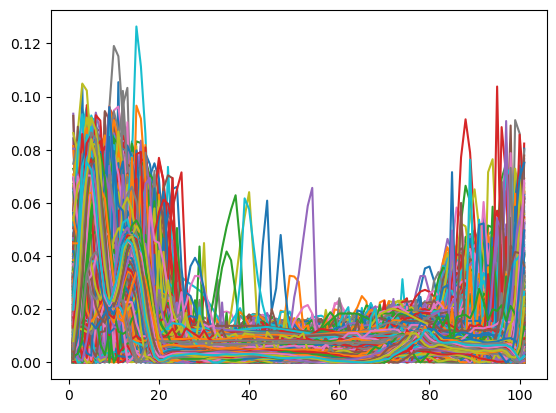

In [99]:
for i in range(10000):
    plt.plot(np.linspace(1,101,101),beatsSinus[i])
plt.show()

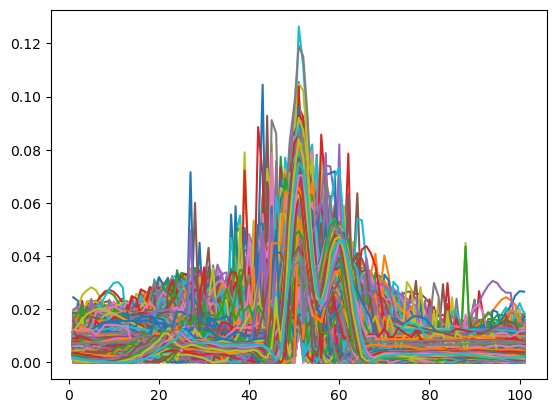

In [10]:
for i in range(10000):
    plt.plot(np.linspace(1,101,101),beatsSinusCentered[i])
plt.show()

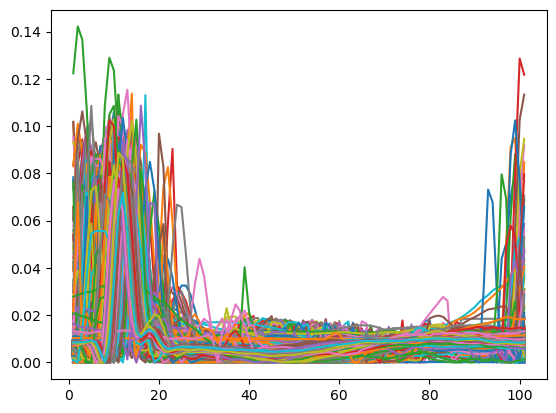

In [100]:
for i in range(10000):
    plt.plot(np.linspace(1,101,101),beatsJet[i])
plt.show()

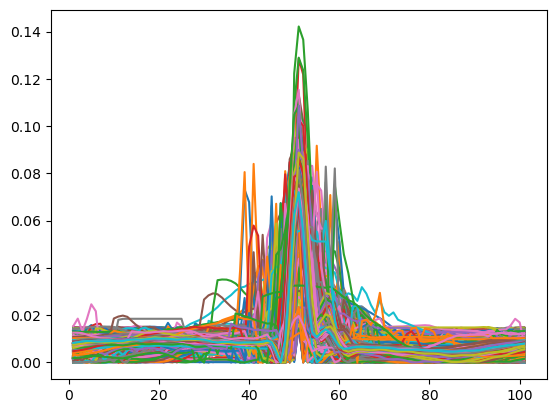

In [36]:

plt.plot(np.linspace(1,101,101),beatsJetCentered[i])
plt.show()

# Average per file

In [37]:
# SINUS euclidean
avgsEucSINUS = np.array([])
fileList = []
for file in fileDictSinus:
    (start, end) = fileDictSinus[file]
    data = beatsSinusCentered[start:end+1]
    avg = np.mean(data, axis=0)
    if len(avgsEucSINUS) == 0:
        avgsEucSINUS = avg
    else:
        avgsEucSINUS = np.vstack((avgsEucSINUS, avg))
    fileList.append(file)
np.savetxt("2.FileAvgEucSinusCent.csv", avgsEucSINUS, delimiter=",")

with open('2.FileNameSInus.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    wr.writerows(fileList)

In [38]:
# JET euclidean
avgsEucJET = np.array([])
fileListJET = []
for file in fileDictJET:
    (start, end) = fileDictJET[file]
    data = beatsJetCentered[start:end+1]
    avg = np.mean(data, axis=0)
    if len(avgsEucJET) == 0:
        avgsEucJET = avg
    else:
        avgsEucJET = np.vstack((avgsEucJET, avg))
    fileListJET.append(file)
np.savetxt("2.FileAvgEucJetCent.csv", avgsEucJET, delimiter=",")

with open('2.FileNameJET.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    wr.writerows(fileListJET)

In [39]:
# SINUS OT
avgsWassSINUS = np.array([])
for file in fileDictSinus:
    (start, end) = fileDictSinus[file]
    data = beatsSinusCentered[start:end+1]
    bary = ot.barycenter(data.T, costMat, 0.001)
    if len(avgsWassSINUS) == 0:
        avgsWassSINUS = bary
    else:
        avgsWassSINUS = np.vstack((avgsWassSINUS, bary))
np.savetxt("2.FileAvgWassSinusCent.csv", avgsWassSINUS, delimiter=",")

In [40]:
# JET OT
avgsWassJET = np.array([])
for file in fileDictJET:
    (start, end) = fileDictJET[file]
    data = beatsJetCentered[start:end+1]
    bary = ot.barycenter(data.T, costMat, 0.001)
    if len(avgsWassJET) == 0:
        avgsWassJET = bary
    else:
        avgsWassJET = np.vstack((avgsWassJET, bary))
np.savetxt("2.FileAvgWassJetCent.csv", avgsWassJET, delimiter=",")

# 3. Pairwise Comparisons

In [44]:
testArr = np.zeros(len(beatsSinusCentered))
for i in range(len(beatsSinusCentered)):
    testArr[i] = ot.emd2(beatsSinusCentered[1], beatsSinusCentered[i], costMat)

In [54]:
testArr2 = np.zeros(len(beatsSinusCentered))
for i in range(len(beatsSinusCentered)):
    testArr2[i] = ot.emd2_1d(beatsSinusCentered[1], beatsSinusCentered[i])



In [74]:
testArr3 = np.zeros(10000)
for i in range(10000):
    testArr3[i] = ot.wasserstein_1d(beatsSinusCentered[1], beatsSinusCentered[i])

In [53]:
testArr3 = np.zeros(len(beatsSinusCentered))
testArr3euc = np.zeros(len(beatsSinusCentered))
for i in range(len(beatsSinusCentered)):
    testArr3[i] = ot.wasserstein_1d(beatsSinusCentered[1], beatsSinusCentered[i])

In [9]:
idx1 = np.array(random.sample(range(len(beatsSinusCentered)), 20000))
idx2 = np.array(random.sample(range(len(beatsJetCentered)), 20000))
idx3 = np.array(random.sample(range(len(beatsSinusCentered)), 5))
idx4 = np.array(random.sample(range(len(beatsJetCentered)), 5))

distMat = np.zeros((40,40000))

for i in range(len(idx1)):
    for j in range(5):
        k = j*4
        distMat[k,i] = ot.emd2(beatsSinusCentered[idx3[j]], beatsSinusCentered[idx1[i]], costMat)
        distMat[k+1,i] = ot.emd2_1d(beatsSinusCentered[idx3[j]], beatsSinusCentered[idx1[i]])
        distMat[k+2,i] = ot.wasserstein_1d(beatsSinusCentered[idx3[j]], beatsSinusCentered[idx1[i]])
        distMat[k+3,i] = np.linalg.norm(beatsSinusCentered[idx3[j]] - beatsSinusCentered[idx1[i]])
        
        k = k+20
        distMat[k,i] = ot.emd2(beatsJetCentered[idx4[j]], beatsSinusCentered[idx1[i]], costMat)
        distMat[k+1,i] = ot.emd2_1d(beatsJetCentered[idx4[j]], beatsSinusCentered[idx1[i]])
        distMat[k+2,i] = ot.wasserstein_1d(beatsJetCentered[idx4[j]], beatsSinusCentered[idx1[i]])
        distMat[k+3,i] = np.linalg.norm(beatsJetCentered[idx4[j]] - beatsSinusCentered[idx1[i]])
        
        l = i+20000
        k = j*4
        distMat[k,l] = ot.emd2(beatsSinusCentered[idx3[j]], beatsJetCentered[idx2[i]], costMat)
        distMat[k+1,l] = ot.emd2_1d(beatsSinusCentered[idx3[j]], beatsJetCentered[idx2[i]])
        distMat[k+2,l] = ot.wasserstein_1d(beatsSinusCentered[idx3[j]], beatsJetCentered[idx2[i]])
        distMat[k+3,l] = np.linalg.norm(beatsSinusCentered[idx3[j]] - beatsJetCentered[idx2[i]])
        
        k = k+20
        distMat[k,l] = ot.emd2(beatsJetCentered[idx4[j]], beatsJetCentered[idx2[i]], costMat)
        distMat[k+1,l] = ot.emd2_1d(beatsJetCentered[idx4[j]], beatsJetCentered[idx2[i]])
        distMat[k+2,l] = ot.wasserstein_1d(beatsJetCentered[idx4[j]], beatsJetCentered[idx2[i]])
        distMat[k+3,l] = np.linalg.norm(beatsJetCentered[idx4[j]] - beatsJetCentered[idx2[i]])
        
        
for i in range(len(distMat)):
    distMat[i,:] = (distMat[i,:] - np.mean(distMat[i,:]))/np.std(distMat[i,:])
np.savetxt("210.distMat.csv", distMat, delimiter=",")

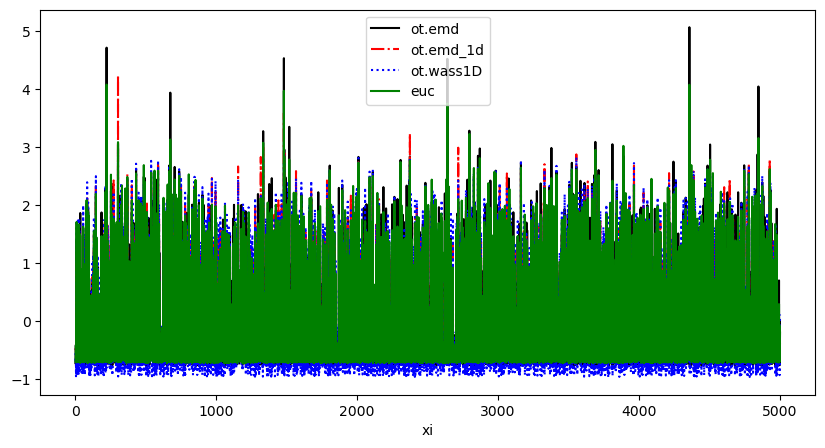

In [29]:
x = np.linspace(1,5000,5000)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, distMat[0,:5000], '-k')
ax.plot(x, distMat[1,:5000], '-.r')
ax.plot(x, distMat[2,:5000], ':b')
ax.plot(x, distMat[4,:5000], 'green')


ax.legend(['ot.emd','ot.emd_1d', 'ot.wass1D', 'euc'])
ax.set(xlabel='xi')

#fig.savefig("denoise_1d_ftrue")
plt.show()

In [93]:
idx = np.array(random.sample(range(len(beatsSinusCentered)), 5000))
pairEucSINUS5kRan = np.zeros((5000,5000))
pairWassSINUS5kRan = np.zeros((5000,5000))

for i in range(len(idx)):
    for j in range(i, len(idx)):
        
        eucDist = np.linalg.norm(beatsSinusCentered[idx[i]] - beatsSinusCentered[idx[j]])
        wassDist = ot.wasserstein_1d(beatsSinusCentered[idx[i]], beatsSinusCentered[idx[j]])
    
        pairEucSINUS5kRan[i,j] = eucDist
        pairEucSINUS5kRan[j,i] = eucDist
        
        pairWassSINUS5kRan[i,j] = wassDist
        pairWassSINUS5kRan[j,i] = wassDist
      
np.savetxt("3.PairBeatEucSinus5kRan.csv", pairEucSINUS5kRan, delimiter=",")
np.savetxt("3.PairBeatWassSinus5kRan.csv", pairWassSINUS5kRan, delimiter=",")
np.savetxt("3.BeatIndexSINUS.csv", idx, delimiter=",")

In [94]:
idx = np.array(random.sample(range(len(beatsJetCentered)), 5000))
pairEucJet5kRan = np.zeros((5000,5000))
pairWassJet5kRan = np.zeros((5000,5000))

for i in range(len(idx)):
    for j in range(i, len(idx)):
        
        eucDist = np.linalg.norm(beatsJetCentered[idx[i]] - beatsJetCentered[idx[j]])
        wassDist = ot.wasserstein_1d(beatsJetCentered[idx[i]], beatsJetCentered[idx[j]])
    
        pairEucJet5kRan[i,j] = eucDist
        pairEucJet5kRan[j,i] = eucDist
        
        pairWassJet5kRan[i,j] = wassDist
        pairWassJet5kRan[j,i] = wassDist
      
np.savetxt("4.PairBeatEucJet5kRan.csv", pairEucJet5kRan, delimiter=",")
np.savetxt("4.PairBeatWassJet5kRan.csv", pairWassJet5kRan, delimiter=",")
np.savetxt("4.BeatIndexJet.csv", idx, delimiter=",")

In [96]:
idx1 = np.array(random.sample(range(len(beatsSinusCentered)), 2500))
idx2 = np.array(random.sample(range(len(beatsJetCentered)), 2500))

allData = np.zeros((5000,101))
allData[:2500,:] = beatsSinusCentered[idx1,:]
allData[2500:,:] = beatsJetCentered[idx2,:]

pairEucSinusAndJet5kRan = np.zeros((5000,5000))
pairWassSinusAndJet5kRan = np.zeros((5000,5000))

for i in range(len(allData)):
    for j in range(i, len(allData)):
        
        eucDist = np.linalg.norm(allData[i] - allData[j])
        wassDist = ot.wasserstein_1d(allData[i], allData[j])
    
        pairEucSinusAndJet5kRan[i,j] = eucDist
        pairEucSinusAndJet5kRan[j,i] = eucDist
        
        pairWassSinusAndJet5kRan[i,j] = wassDist
        pairWassSinusAndJet5kRan[j,i] = wassDist
      
np.savetxt("5.PairEucSinusAndJet5kRan.csv", pairEucSinusAndJet5kRan, delimiter=",")
np.savetxt("5.PairWassSinusAndJet5kRan.csv", pairWassSinusAndJet5kRan, delimiter=",")
np.savetxt("5.BeatIndexJet.csv", idx2, delimiter=",")
np.savetxt("5.BeatIndexSinus.csv", idx1, delimiter=",")

In [97]:
idx = np.array(random.sample(range(len(beatsJetCentered)), 5000))
EucFileVsJet5kRanEuc = np.zeros((len(avgsEucSINUS),5000))
EucFileVsJet5kRanWass = np.zeros((len(avgsEucSINUS),5000))
WassFileVsJet5kRanEuc = np.zeros((len(avgsWassSINUS),5000))
WassFileVsJet5kRanWass = np.zeros((len(avgsWassSINUS),5000))
for i in range(len(avgsWassSINUS)):
    for j in range(len(idx)):
        
        eucDist1 = np.linalg.norm(avgsEucSINUS[i] - beatsJetCentered[idx[j]])
        eucDist2 = np.linalg.norm(avgsWassSINUS[i] - beatsJetCentered[idx[j]])

        wassDist1 = ot.wasserstein_1d(avgsEucSINUS[i], beatsJetCentered[idx[j]])
        wassDist2 = ot.wasserstein_1d(avgsWassSINUS[i], beatsJetCentered[idx[j]])
    
        EucFileVsJet5kRanEuc[i,j] = eucDist1
        WassFileVsJet5kRanEuc[i,j] = eucDist2
        
        EucFileVsJet5kRanWass[i,j] = wassDist1
        WassFileVsJet5kRanWass[i,j] = wassDist2
      
np.savetxt("6.EucFileVsJet5kRanEuc.csv", EucFileVsJet5kRanEuc, delimiter=",")
np.savetxt("6.EucFileVsJet5kRanWass.csv", EucFileVsJet5kRanWass, delimiter=",")
np.savetxt("6.WassFileVsJet5kRanEuc.csv", WassFileVsJet5kRanEuc, delimiter=",")
np.savetxt("6.WassFileVsJet5kRanWass.csv", WassFileVsJet5kRanWass, delimiter=",")

np.savetxt("6.BeatIndexJet.csv", idx, delimiter=",")

In [98]:
idx = np.array(random.sample(range(len(beatsSinusCentered)), 5000))
EucFileVsSinus5kRanEuc = np.zeros((len(avgsEucJET),5000))
EucFileVsSinus5kRanWass = np.zeros((len(avgsEucJET),5000))
WassFileVsSinus5kRanEuc = np.zeros((len(avgsWassJET),5000))
WassFileVsSinus5kRanWass = np.zeros((len(avgsWassJET),5000))
for i in range(len(avgsWassJET)):
    for j in range(len(idx)):
        
        eucDist1 = np.linalg.norm(avgsEucJET[i] - beatsSinusCentered[idx[j]])
        eucDist2 = np.linalg.norm(avgsWassJET[i] - beatsSinusCentered[idx[j]])

        wassDist1 = ot.wasserstein_1d(avgsEucJET[i], beatsSinusCentered[idx[j]])
        wassDist2 = ot.wasserstein_1d(avgsWassJET[i], beatsSinusCentered[idx[j]])
    
        EucFileVsSinus5kRanEuc[i,j] = eucDist1
        WassFileVsSinus5kRanEuc[i,j] = eucDist2
        
        EucFileVsSinus5kRanWass[i,j] = wassDist1
        WassFileVsSinus5kRanWass[i,j] = wassDist2
      
np.savetxt("7.EucFileVsSinus5kRanEuc.csv", EucFileVsSinus5kRanEuc, delimiter=",")
np.savetxt("7.EucFileVsSinus5kRanWass.csv", EucFileVsSinus5kRanWass, delimiter=",")
np.savetxt("7.WassFileVsSinus5kRanEuc.csv", WassFileVsSinus5kRanEuc, delimiter=",")
np.savetxt("7.WassFileVsSinus5kRanWass.csv", WassFileVsSinus5kRanWass, delimiter=",")

np.savetxt("7.BeatIndexSinus.csv", idx, delimiter=",")

# Compute full averages vs. 10 random files

In [18]:
fileDictJETcount = {}
fileDictSinuscount = {}
for file in fileDictSinus:
    fileDictSinuscount[file] = fileDictSinus[file][1] - fileDictSinus[file][0]
for file in fileDictJET:
    fileDictJETcount[file] = fileDictJET[file][1] - fileDictJET[file][0]
    
fileJet1000 = []
fileSinus1000 = []
for file in fileDictSinuscount:
    if fileDictSinuscount[file] > 1000:
        fileSinus1000.append(file)
for file in fileDictJETcount:
    if fileDictJETcount[file] > 1000:
        fileJet1000.append(file)

In [15]:
idx1 = np.array(random.sample(range(len(fileSinus1000)), 5))
idx2 = np.array(random.sample(range(len(fileJet1000)), 5))

allBeats = np.array([])
countSinus = 0
for i in idx1:
    file = fileSinus1000[i]
    k, l = fileDictSinus[file]
    for j in range(k, l+1):
        countSinus += 1
        if (len(allBeats) == 0):
            allBeats = beatsSinusCentered[j]
        else:
            allBeats = np.vstack((allBeats, beatsSinusCentered[j]))
countJet = 0
for i in idx2:
    file = fileJet1000[i]
    k, l = fileDictJET[file]
    for j in range(k, l+1):
        countJet += 1
        allBeats = np.vstack((allBeats, beatsJetCentered[j]))           

In [10]:
sinusEucAvg = np.loadtxt(r"C:\Users\fanga\OneDrive\Documents\Fall 2023\elec 594\THC Docs\Freddy's Code\Deliverables (2)\1.SinusCentAvgEuc.csv",delimiter=",")
jetEucAvg = np.loadtxt(r"C:\Users\fanga\OneDrive\Documents\Fall 2023\elec 594\THC Docs\Freddy's Code\Deliverables (2)\1.JETCentAvgEuc.csv",delimiter=",")
sinusBary = np.loadtxt(r"C:\Users\fanga\OneDrive\Documents\Fall 2023\elec 594\THC Docs\Freddy's Code\Deliverables (2)\1.SinusCentAvgOT.csv",delimiter=",")
jetBary = np.loadtxt(r"C:\Users\fanga\OneDrive\Documents\Fall 2023\elec 594\THC Docs\Freddy's Code\Deliverables (2)\1.JetCentAvgOT.csv",delimiter=",")

In [19]:
allBeats = np.array([])
countSinus = 0
for i in idx1:
    file = fileSinus1000[i]
    k, l = fileDictSinus[file]
    for j in range(k, l+1):
        countSinus += 1
        if (len(allBeats) == 0):
            allBeats = beatsSinusCentered[j]
        else:
            allBeats = np.vstack((allBeats, beatsSinusCentered[j]))
countJet = 0
for i in idx2:
    file = fileJet1000[i]
    k, l = fileDictJET[file]
    for j in range(k, l+1):
        countJet += 1
        allBeats = np.vstack((allBeats, beatsJetCentered[j]))

In [22]:
avgVsBeatsEuc = np.zeros((4, len(allBeats)))
avgVsBeatsWass = np.zeros((4, len(allBeats)))

for i in range(4):
    for j in range(len(allBeats)):
        dist1 = np.linalg.norm(averages[i] - allBeats[j])
        dist2 = ot.wasserstein_1d(averages[i], allBeats[j], p =2)
        
        avgVsBeatsEuc[i,j] = dist1
        avgVsBeatsWass[i,j] = dist2
np.savetxt("8.avgVsBeatsEucP2.csv", avgVsBeatsEuc, delimiter=",")
np.savetxt("8.avgVsBeatsWassP2.csv", avgVsBeatsWass, delimiter=",")

# Pairwise of File averages

In [36]:
fileAvgEucJet = np.loadtxt(r"C:\Users\fanga\OneDrive\Documents\Fall 2023\elec 594\THC Docs\Freddy's Code\Deliverables (2)\2.FileAvgEucJetCent.csv",delimiter=",")
fileAvgEucSinus = np.loadtxt(r"C:\Users\fanga\OneDrive\Documents\Fall 2023\elec 594\THC Docs\Freddy's Code\Deliverables (2)\2.FileAvgEucSinusCent.csv",delimiter=",")
fileBaryJet = np.loadtxt(r"C:\Users\fanga\OneDrive\Documents\Fall 2023\elec 594\THC Docs\Freddy's Code\Deliverables (2)\2.FileAvgWassJetCent.csv",delimiter=",")
fileBarySinus = np.loadtxt(r"C:\Users\fanga\OneDrive\Documents\Fall 2023\elec 594\THC Docs\Freddy's Code\Deliverables (2)\2.FileAvgWassSinusCent.csv",delimiter=",")

In [37]:
allAvgFiles = fileAvgEucJet
allAvgFiles = np.vstack((allAvgFiles, fileAvgEucSinus, fileBaryJet, fileBarySinus))

In [40]:
pairFileAvgEuc = np.zeros((len(allAvgFiles), len(allAvgFiles)))
pairFileAvgWass = np.zeros((len(allAvgFiles), len(allAvgFiles)))

for i in range(len(allAvgFiles)):
    for j in range(i, len(allAvgFiles)):
        dist1 = np.linalg.norm(allAvgFiles[i] - allAvgFiles[j])
        dist2 = ot.wasserstein_1d(allAvgFiles[i], allAvgFiles[j])
        
        pairFileAvgEuc[i,j] = dist1
        pairFileAvgEuc[j,i] = dist1
        pairFileAvgWass[i,j] = dist2
        pairFileAvgWass[j,i] = dist2
np.savetxt("9.pairFileAvgEuc.csv", pairFileAvgEuc, delimiter=",")
np.savetxt("9.pairFileAvgWass.csv", pairFileAvgWass, delimiter=",")